In [1]:
source('setup.R')
df <- readRDS('nsclc_egfr_pm25_09022015.rds')

In [2]:
OUTCOME <- "EGFR"
COVAR_OF_INTEREST <- "PM25"
SECONDARY_MUT <- ifelse(OUTCOME == "EGFR", "KRAS", "EGFR")

COVAR_BASELINE <- c(
    "AGE", "GENDER_NM", "PANEL_VERSION", "STAGE", "YEAR_TEST", "SMOKE3", 
    "PC1", "PC2", "PC3", "PC4", "PC5", "LUAD"
)
COVAR_TMB <- "MUTATIONAL_BURDEN"
COVAR_SES <- c("avg_pct_poverty", "avg_med_income", "avg_pct_low_edu")

# 1. Distribution of Profile ancestry

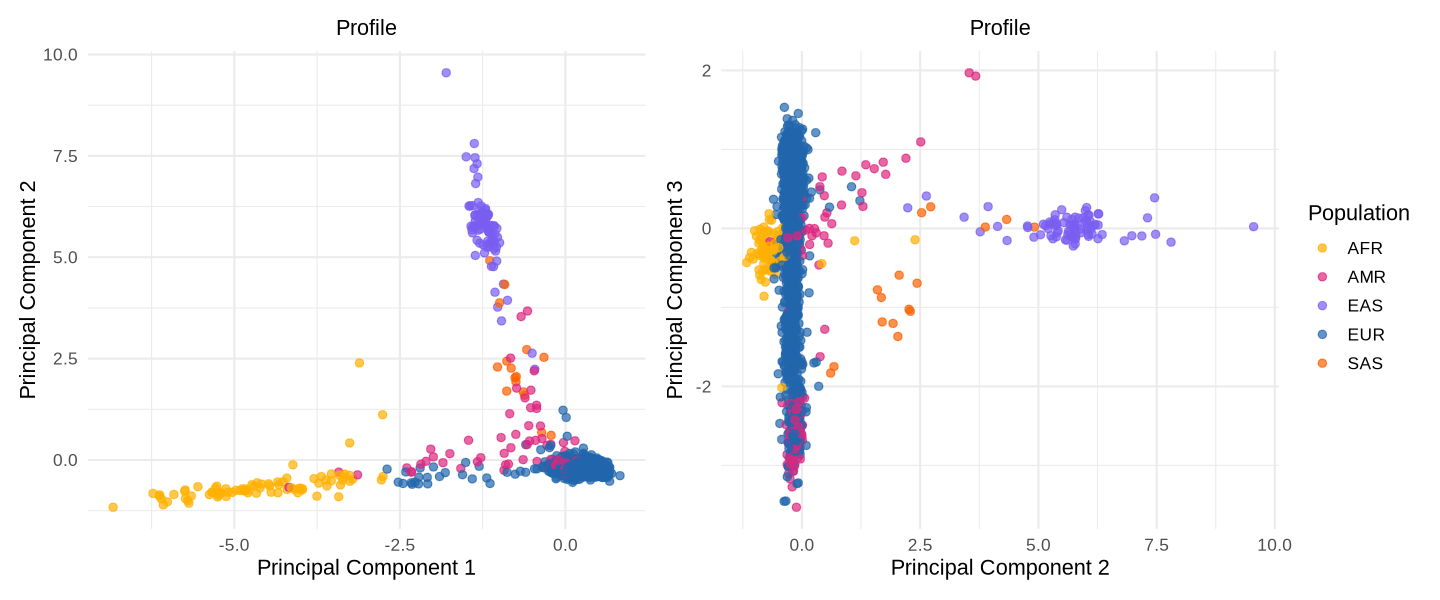

In [3]:
library(ggplot2)
library(dplyr)
library(patchwork) 
options(repr.plot.height = 5, repr.plot.width = 12)
# Define your custom color palette
color_palette <- c(
  "EUR" = "#2166AC",
  "AMR" = "#DC267F",
  "AFR" = "#FFB000",
  "EAS" = "#785EF0",
  "SAS" = "#FE6100"
)


# Plot 1: PC1 vs PC2
p1 <- ggplot(df, aes(x = PC1, y = PC2, color = Predicted_Pop)) +
    geom_point(alpha = 0.7, size = 2) +
    scale_color_manual(values = color_palette) +
    labs(
        x = "Principal Component 1",
        y = "Principal Component 2",
        color = "Population",
        subtitle = 'Profile'
    ) +
    theme_minimal(base_size = 13) +
    theme(
        legend.position = "right",
        plot.title = element_text(face = "bold"),
        plot.subtitle = element_text(hjust = 0.5)
    )

# Plot 2: PC2 vs PC3
p2 <- ggplot(df, aes(x = PC2, y = PC3, color = Predicted_Pop)) +
    geom_point(alpha = 0.7, size = 2) +
    scale_color_manual(values = color_palette) +
    labs(
        x = "Principal Component 2",
        y = "Principal Component 3",
        color = "Population",
        subtitle = 'Profile'
    ) +
    theme_minimal(base_size = 13) +
    theme(
        legend.position = "none",  
        plot.title = element_text(face = "bold"),
        plot.subtitle = element_text(hjust = 0.5)
    )

# Combine with patchwork
p1 + p2 + plot_layout(guides = "collect")
ggsave('result/profile_pca.pdf', h = 5, w = 11)

In [4]:
df %>% group_by(Predicted_Pop) %>% 
    summarize(
        EGFR = mean(EGFR), 
        PM25 = mean(PM25), 
        count = n(),
        never_smoker = sum(!SMOKE3)
    )

Predicted_Pop,EGFR,PM25,count,never_smoker
<chr>,<dbl>,<dbl>,<int>,<int>
AFR,0.2650602,9.108883,83,24
AMR,0.2500000,8.870150,140,44
EAS,0.5903614,9.356633,83,54
EUR,0.1829585,8.322779,2312,435
SAS,0.7500000,9.465897,16,9


# 2. Stats for All NSCLC

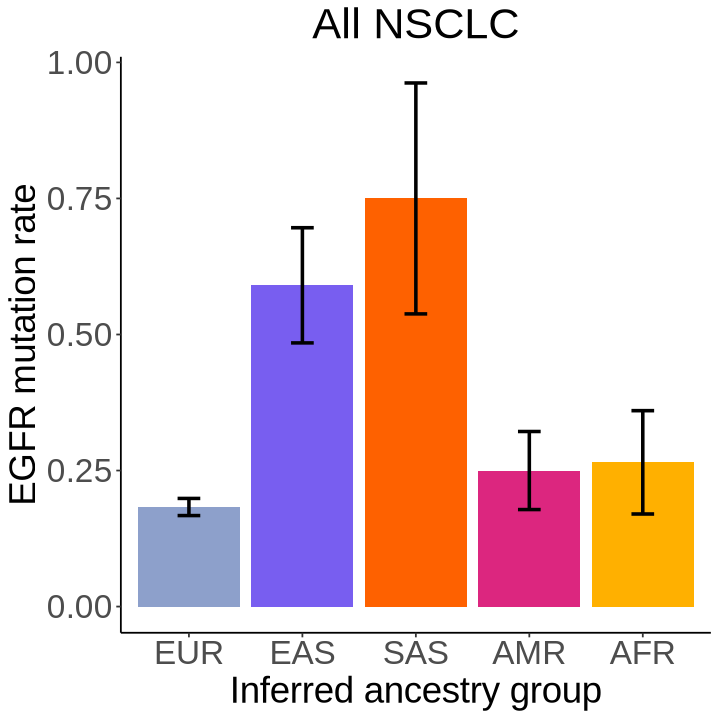

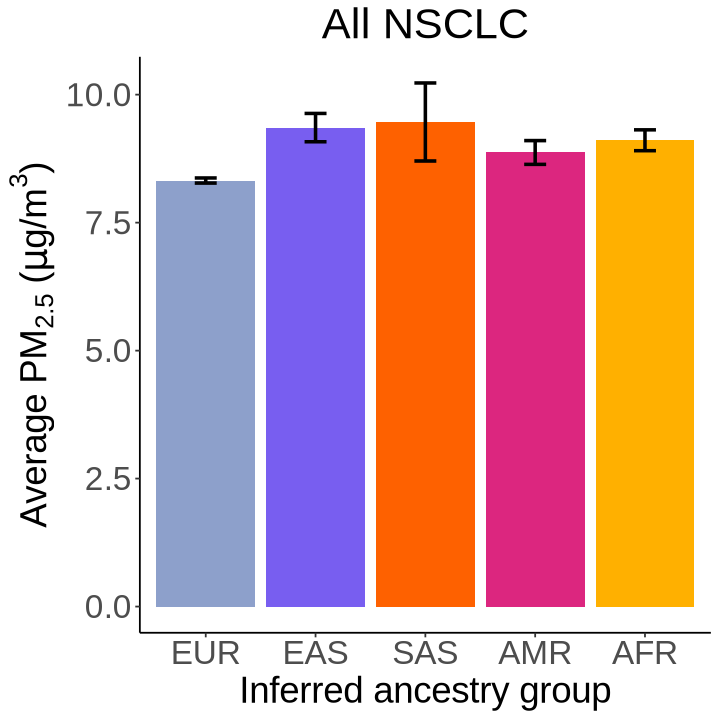

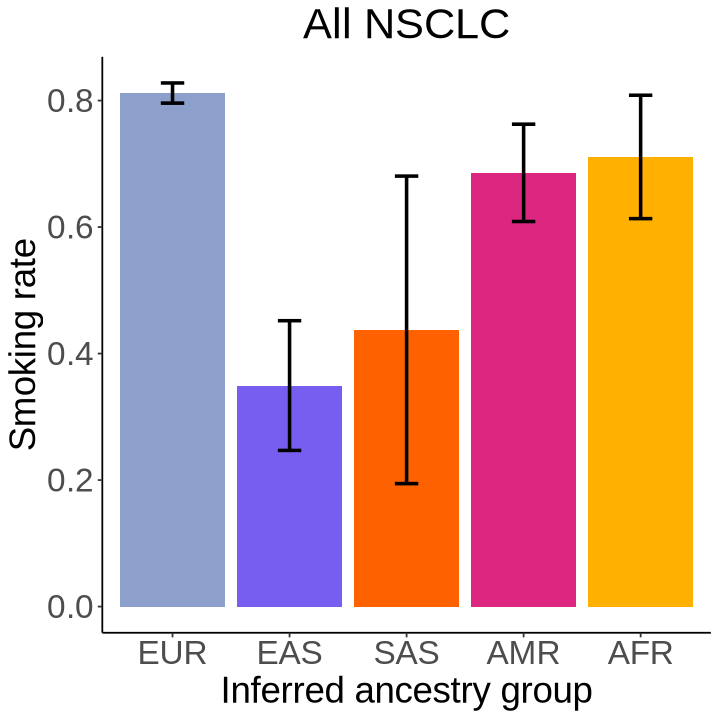

In [5]:
# Load required library
library(dplyr)
library(ggplot2)

# Set figure size
set_fig_size(6, 6)

# Create summary data frame with mean and 95% CI
prev_df <- df %>%
    group_by(Predicted_Pop) %>%
    summarize(
        n = n(),
        PM25_se = sd(PM25) / sqrt(n),  # Standard error for continuous
        EGFR = mean(EGFR),
        PM25 = mean(PM25),
        SMOKE3 = mean(SMOKE3),
        EGFR_se = sqrt(EGFR * (1 - EGFR) / n),  # Binomial standard error for proportion
        SMOKE3_se = sqrt(SMOKE3 * (1 - SMOKE3) / n)
    ) %>%
    arrange(desc(n)) %>%
    mutate(Predicted_Pop = factor(Predicted_Pop, levels = c('EUR', 'EAS', 'SAS', 'AMR', 'AFR')))

# Define color palette
color_palette <- c(
    "EUR" = "#8da0cb",
    "AMR" = "#DC267F",
    "AFR" = "#FFB000",
    "EAS" = "#785EF0",
    "SAS" = "#FE6100"
)


# Plot EGFR prevalence with 95% CI
ggplot(prev_df, aes(x = Predicted_Pop, y = EGFR, fill = Predicted_Pop)) +
    geom_col() +
    geom_errorbar(aes(ymin = EGFR - 1.96 * EGFR_se, ymax = EGFR + 1.96 * EGFR_se),
                  width = 0.2, size = 1) +
    my_theme(base_font_size = 20) +
    scale_fill_manual(values = color_palette) +
    labs(y = 'EGFR mutation rate', x = 'Inferred ancestry group')  +
    theme(legend.position = "none") + ggtitle('All NSCLC')+  theme(plot.title = element_text(hjust = 0.5))
ggsave(filename = "result/EGFR_prevalence.pdf", width = 6, height = 6)

# Plot Average PM25 with 95% CI
ggplot(prev_df, aes(x = Predicted_Pop, y = PM25, fill = Predicted_Pop)) +
    geom_col() +
    geom_errorbar(aes(ymin = PM25 - 1.96 * PM25_se, ymax = PM25 + 1.96 * PM25_se),
                  width = 0.2, size = 1) +
    my_theme(base_font_size = 20) +
    scale_fill_manual(values = color_palette) +
    labs(y = expression("Average PM"[2.5]*" ("*mu*"g/m"^3*")"), x = 'Inferred ancestry group')  +
    theme(legend.position = "none") + ggtitle('All NSCLC')+  theme(plot.title = element_text(hjust = 0.5))
ggsave(filename = "result/Average_PM25.pdf", width = 6, height = 6)

# Plot Prevalence of Smoking with 95% CI
ggplot(prev_df, aes(x = Predicted_Pop, y = SMOKE3, fill = Predicted_Pop)) +
    geom_col() +
    geom_errorbar(aes(ymin = SMOKE3 - 1.96 * SMOKE3_se, ymax = SMOKE3 + 1.96 * SMOKE3_se),
                  width = 0.2, size = 1) +
    my_theme(base_font_size = 20) +
    scale_fill_manual(values = color_palette) +
    labs(y = 'Smoking rate', x = 'Inferred ancestry group')  +
    theme(legend.position = "none") + ggtitle('All NSCLC') +  theme(plot.title = element_text(hjust = 0.5))
ggsave(filename = "result/Prevalence_of_Smoking.pdf", width = 6, height = 6)

# 2. Stats for Never smokers

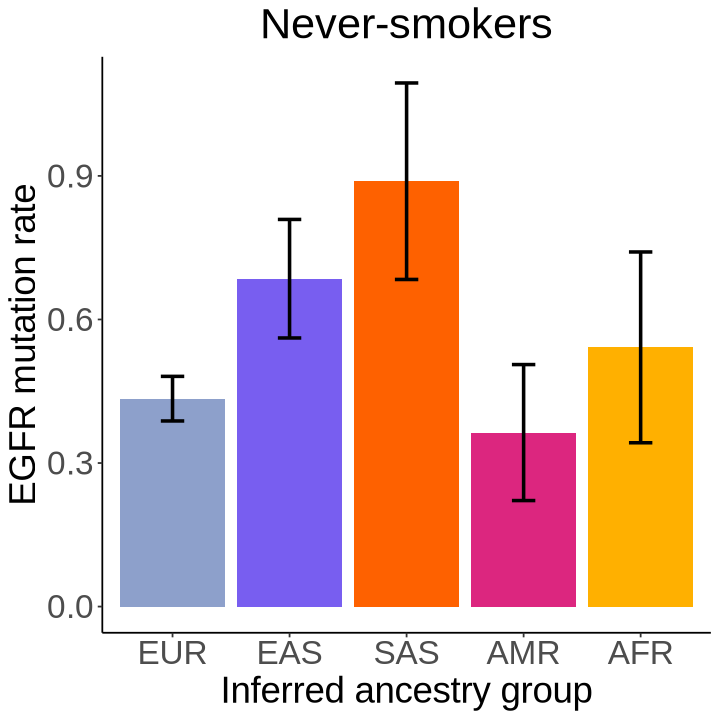

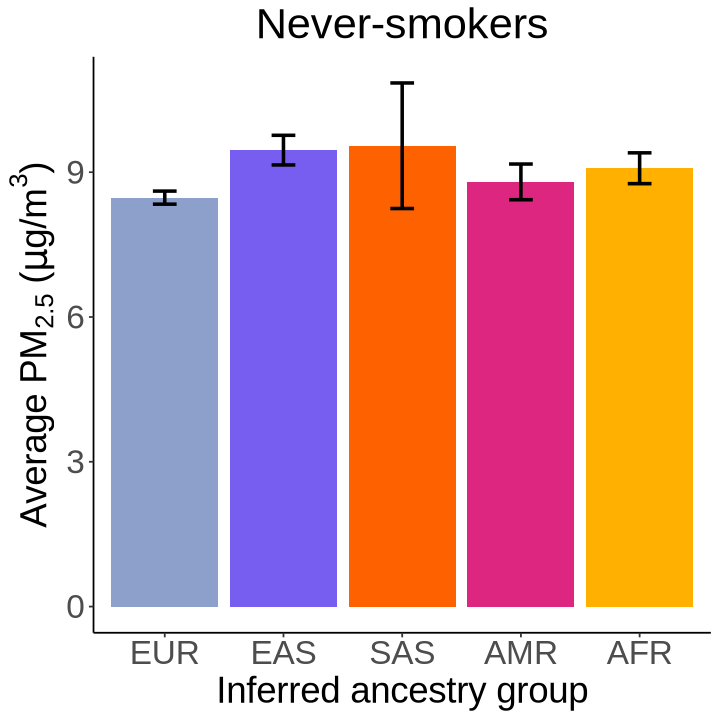

In [6]:
# Set figure size
set_fig_size(6, 6)

# Create summary data frame with mean and 95% CI
prev_df <- df %>% filter(!SMOKE3) %>%
    group_by(Predicted_Pop) %>%
    summarize(
        n = n(),
        PM25_se = sd(PM25) / sqrt(n),  # Standard error for continuous
        EGFR = mean(EGFR),
        PM25 = mean(PM25),
        SMOKE3 = mean(SMOKE3),
        EGFR_se = sqrt(EGFR * (1 - EGFR) / n),  # Binomial standard error for proportion
        SMOKE3_se = sqrt(SMOKE3 * (1 - SMOKE3) / n)
    ) %>%
    arrange(desc(n)) %>%
    mutate(Predicted_Pop = factor(Predicted_Pop, levels = c('EUR', 'EAS', 'SAS', 'AMR', 'AFR')))

# Plot EGFR prevalence with 95% CI
ggplot(prev_df, aes(x = Predicted_Pop, y = EGFR, fill = Predicted_Pop)) +
    geom_col() +
    geom_errorbar(aes(ymin = EGFR - 1.96 * EGFR_se, ymax = EGFR + 1.96 * EGFR_se),
                  width = 0.2, size = 1) +
    my_theme(base_font_size = 20) +
    scale_fill_manual(values = color_palette) +
    labs(y = 'EGFR mutation rate', x = 'Inferred ancestry group')  +
    theme(legend.position = "none") + ggtitle('Never-smokers')+  theme(plot.title = element_text(hjust = 0.5))
ggsave(filename = "result/EGFR_prevalence_ns.pdf", width = 6, height = 6)

# Plot Average PM25 with 95% CI
ggplot(prev_df, aes(x = Predicted_Pop, y = PM25, fill = Predicted_Pop)) +
    geom_col() +
    geom_errorbar(aes(ymin = PM25 - 1.96 * PM25_se, ymax = PM25 + 1.96 * PM25_se),
                  width = 0.2, size = 1) +
    my_theme(base_font_size = 20) +
    scale_fill_manual(values = color_palette) +
    labs(y = expression("Average PM"[2.5]*" ("*mu*"g/m"^3*")"), x = 'Inferred ancestry group')  +
    theme(legend.position = "none") + ggtitle('Never-smokers')+  theme(plot.title = element_text(hjust = 0.5))
ggsave(filename = "result/Average_PM25_ns.pdf", width = 6, height = 6)

# 4. Mediation analysis

In [7]:
reg_df <- bind_rows(
    df %>% mutate(group = ifelse(SMOKE3, 'Smokers', 'Never-smokers')),
    df %>% mutate(group = 'All')
) %>% 
    mutate(group = factor(group, levels = c('All', 'Never-smokers', 'Smokers'))) 
reg_df <- df %>%
    filter(Predicted_Pop %in% c('EAS', 'EUR')) 

table(reg_df$Predicted_Pop)


 EAS  EUR 
  83 2312 

In [8]:
library(mediation)
# Model for the mediator 
model_PM25 <- lm(PM25 ~ AGE + PANEL_VERSION + GENDER_NM + STAGE + Predicted_Pop  + YEAR_TEST + SMOKE3 + LUAD + MUTATIONAL_BURDEN + avg_pct_poverty + avg_med_income + avg_pct_low_edu,  data=reg_df)

# Model for the outcome 
model_EGFR <- glm(EGFR ~ PM25 + Predicted_Pop +  AGE + PANEL_VERSION + GENDER_NM + STAGE  + SMOKE3 + YEAR_TEST + LUAD + MUTATIONAL_BURDEN + avg_pct_poverty + avg_med_income + avg_pct_low_edu, 
                  data=reg_df, family = binomial())

# Conduct mediation analysis
med.out <- mediate(model_PM25, model_EGFR, treat="Predicted_Pop", mediator="PM25")
summary(med.out)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:patchwork’:

    area


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: mvtnorm

Loading required package: sandwich

mediation: Causal Mediation Analysis
Version: 4.5.0





Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

                         Estimate 95% CI Lower 95% CI Upper p-value    
ACME (control)           -0.01243     -0.02774         0.00   0.024 *  
ACME (treated)           -0.00851     -0.01848         0.00   0.024 *  
ADE (control)            -0.23155     -0.34021        -0.13  <2e-16 ***
ADE (treated)            -0.22762     -0.33643        -0.13  <2e-16 ***
Total Effect             -0.24005     -0.35089        -0.15  <2e-16 ***
Prop. Mediated (control)  0.04999      0.00478         0.13   0.024 *  
Prop. Mediated (treated)  0.03404      0.00315         0.09   0.024 *  
ACME (average)           -0.01047     -0.02308         0.00   0.024 *  
ADE (average)            -0.22958     -0.33833        -0.13  <2e-16 ***
Prop. Mediated (average)  0.04202      0.00392         0.11   0.024 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 2395 


Simulations: 1000 


In [9]:
# model for mediator, smoking
model_SMOKE <- glm(SMOKE3 ~  PM25 + AGE + PANEL_VERSION + GENDER_NM + STAGE + Predicted_Pop + YEAR_TEST + LUAD + MUTATIONAL_BURDEN + avg_pct_poverty + avg_med_income + avg_pct_low_edu, data=reg_df, family = binomial)

# Model for the outcome EGFR
model_EGFR <- glm(EGFR ~ PM25 + Predicted_Pop +  AGE + PANEL_VERSION + GENDER_NM + STAGE  + SMOKE3 + YEAR_TEST + LUAD + MUTATIONAL_BURDEN + avg_pct_poverty + avg_med_income + avg_pct_low_edu, data=reg_df, family = binomial)

# Conduct mediation analysis
med.out <- mediate(model_SMOKE, model_EGFR, treat="Predicted_Pop", mediator="SMOKE3")
summary(med.out)


Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

                         Estimate 95% CI Lower 95% CI Upper p-value    
ACME (control)            -0.0984      -0.1323        -0.07  <2e-16 ***
ACME (treated)            -0.0786      -0.1073        -0.05  <2e-16 ***
ADE (control)             -0.2492      -0.3434        -0.15  <2e-16 ***
ADE (treated)             -0.2293      -0.3285        -0.13  <2e-16 ***
Total Effect              -0.3278      -0.4231        -0.22  <2e-16 ***
Prop. Mediated (control)   0.3006       0.1867         0.45  <2e-16 ***
Prop. Mediated (treated)   0.2382       0.1532         0.36  <2e-16 ***
ACME (average)            -0.0885      -0.1187        -0.06  <2e-16 ***
ADE (average)             -0.2393      -0.3356        -0.14  <2e-16 ***
Prop. Mediated (average)   0.2694       0.1712         0.41  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 2395 


Simulations: 1000 
